In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*In this notebook we explore how at the conceptual stage, it is possible to rapidly estimate the **induced-drag factor** from basic parameters of an aircraft concept's geometry.*

In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Aircraft Performance L3 - Estimating The Induced Drag Factor

## Estimating $k$ for Subsonic Aircraft: The Oswald efficiency factor $e_0$

### Speedy Estimates

- Cavallo, Subsonic Drag Estimation Methods, U.S. Naval Air Development Center

$$
\begin{eqnarray}
e_{0, \text{straightwing}} &=& 1.78(1-0.045 \cdot AR^{0.68}) - 0.64 &\qquad& [\Lambda_{LE} = 0^{\circ}] \\
e_{0, \text{sweptwing}} &=& 4.61(1-0.045 \cdot AR^{0.68})(\cos\Lambda_{LE})^{0.15} - 3.1 &\qquad& [\Lambda_{LE} > 30^{\circ}]
\end{eqnarray}
$$

> where $\Lambda_{LE}$ is the sweep angle of the leading edge.

In [3]:
def e0_cavallo_straight(AR):
    e0 = 1.78 * (1 - 0.045 * AR ** 0.68) - 0.64
    return e0

def e0_cavallo_swept(AR, sweepLE):
    e0 = 4.61 * (1 - 0.045 * AR ** 0.68) * np.cos(sweepLE) ** 0.15 - 3.1
    return e0

def e0_cavallo_mixed(AR, sweepLE):
    wt = np.interp(sweepLE, [0, np.radians(30)], [1, 0])
    e0_mixed = wt * e0_cavallo_straight(AR) + (1 - wt) * e0_cavallo_swept(AR, sweepLE)
    return e0_mixed

- Brandt et al, Introduction to Aeronautics -- a Design perspective, AIAA Education Series

$$e = \frac{2}{2 - AR + \sqrt{4 + AR^2(1 + \tan^2 \Lambda_{MT})}}$$

> where $\Lambda_{MT}$ is the sweep angle of the maximum thickness chord station.

where we have introduced the planform *span efficiency factor* $e$ and the wing's effective aspect ratio $AR$.
Classically, we are taught that $C_{D_0}$ can be taken as a constant - and then drag is readily estimated from the conditions of flight ($C_L$), and properties of the wing geometry ($e$ and $AR$).

In [4]:
def e_brandt(AR, sweepMT):
    e = 2 / (2 - AR + (4 + AR**2 * (1 + np.tan(sweepMT)**2)) ** 0.5)
    return e

- Nita  and Scholz, Estimating the Oswald Factor from Basic Aircraft Geometrical Parameters

> A taper ratio $\lambda$ correction:

$$\Delta \lambda = -0.357 + 0.45 \cdot exp(-0.0375 \cdot \Lambda_{25, deg})$$

$$\lambda_H = \lambda - \Delta \lambda$$

> where $\Lambda_{25, deg}$ is the sweep angle of the quarter-chord line in degrees.

> Hoerner's inviscid span efficiency estimate:

$$\frac{\delta}{AR} = 0.0524{(\lambda_H)}^4 - 0.15{(\lambda_H)}^3 + 0.1659{(\lambda_H)}^2 -0.0706{(\lambda_H)}  + 0.0119 $$

$$e = \frac{1}{1 + \big{(}\frac{\delta}{AR}\big{)}AR}$$

> Correction for Fuselage presence (from Kroo):

$$k_{e, F} = 1 - 2 {\bigg{(}\frac{d_F}{b}\bigg{)}}^2 \hspace{1cm} \bigg{[}\frac{d_F}{b}=0.114\bigg{]}$$

> where $d_F / b$ is the ratio of fuselage diameter to wingspan, and is given as the average of a sample of GA aircraft.

> Correction for viscous drag from lift:

$$k_{e, D_0} = 0.85$$

> Correction for compressibility effects, based on empirical fit of subsonic transport aircraft :

$$k_{e, M} = \begin{cases}
M_{\infty} \leq 0.3: 1\\
M_{\infty} > 0.3: 1 - 0.001521 {\big{(}\frac{M_{\infty}}{0.3}-1\big{)}}^{10.82}\\
\end{cases}$$

> where $M_{\infty}$ is the free-stream Mach number.

> Finally, the Oswald efficiency number:

$$e_0 = e \cdot k_{e, F} \cdot k_{e, D_0} \cdot k_{e, M}$$

In [5]:
def e0_nitascholz(AR, sweep25, TR, Mach):
    # Map taper ratio to Hoerner's taper ratio
    dlamda = -0.357 + 0.45 * np.exp(-0.0375 * np.degrees(sweep25))
    lamdaH = TR - dlamda
    
    # Estimate the span efficiency, e
    delta_by_AR = 0.0524 * lamdaH ** 4 - 0.15 * lamdaH ** 3 + 0.1659 * lamdaH ** 2 - 0.0706 * lamdaH + 0.0119
    delta = delta_by_AR * AR
    e_theory = 1 / (1 + delta)
    
    # Correction factors
    ke_f = 1 - 2 * (0.114) ** 2
    ke_d0 = 0.85
    ke_M = np.where(Mach <= 0.3, 1, 1 - 0.001521 * (Mach / 0.3)**10.82)
    
    e_0 = e_theory * ke_f * ke_d0 * ke_M
    
    return e_0

- Obert, E. -- Aerodynamic Design of Transport Aircraft, AIAA Education Series

$$e_0 = \frac{1}{1.05 + 0.007 \cdot \pi \text{AR}}$$

> where $\Lambda_{MT}$ is the sweep angle of the maximum thickness chord station.

In [6]:
def e0_obert(AR):
    e0 = 1 / (1.05 + 0.007 * np.pi * AR)
    return e0

- Kroo, I. -- Aircraft Design: Synthesis and Analysis

$$e_0 = \frac{1}{\tfrac{1}{e_i} + 0.38 \cdot C_{D_0} \pi \text{AR}}$$

> where $e_i$ is the inviscid span efficiency factor

$$
e_i = u \times s
\quad \text{with} \quad u \sim [0.98,1]\, ,\quad s \sim 0.975
$$

In [7]:
def e0_kroo(AR, CD0):
    u = 0.99
    s = 0.975  # Fuselage correction, s = 1 - 2 * (df/b)^2
    ei = u * s
    e0 = 1 / (1 / ei + 0.38 * np.pi * AR * CD0)
    return e0

- Cavallo's method is suited for "moderate" aspect ratios, and will not work with sailplanes/gliders.
- Brandt's method estimates the span efficiency $e$, not the Oswald span efficiency $e_0$.
- Nita-Scholz and Obert's estimates are for subsonic transport aircraft.
- Kroo's estimate was developed based on subsonic airliners.

### Leading Edge Suction Method

A slightly more involved but still relatively simple method to implement is Daniel P. Raymer's Leading Edge Suction Method.
It is not yet implemented in ADRpy.

### Oswald efficiency $e_0$ vs. Aspect Ratio

Clearly, these models for efficiency factors depend on more than just the aspect ratio of the design.
Since it is the only common factor between all the methods, we can investigate the effect of aspect ratio on the efficiency factors.

In [8]:
def plot_e0_vs_AR(sweep_deg, plot_title):
    ARs = np.linspace(2, 30)
    sweep = np.radians(sweep_deg)
    
    fig, axs = plt.subplots(2, dpi=140, figsize=(6, 6), sharex=True)
    axs[0].plot(ARs, e0_cavallo_mixed(ARs, sweep), label="Cavallo, mixed")
    axs[0].plot(ARs, e0_nitascholz(ARs, sweep, 1, 0), label="Nita-Scholz")
    axs[0].plot(ARs, e0_obert(ARs), label="Obert")
    axs[0].plot(ARs, e0_kroo(ARs, 0.02), label="Kroo")
    axs[0].set_title(plot_title)
    axs[0].set_ylabel("Oswald factor, $e_0$")
    axs[0].set_ylim(0, 1)

    axs[1].plot(ARs, 1 / np.pi / e0_cavallo_mixed(ARs, sweep) / ARs, label="Cavallo, mixed")
    axs[1].plot(ARs, 1 / np.pi / e0_nitascholz(ARs, sweep, 1, 0) / ARs, label="Nita-Scholz")
    axs[1].plot(ARs, 1 / np.pi / e0_obert(ARs) / ARs, label="Obert")
    axs[1].plot(ARs, 1 / np.pi / e0_kroo(ARs, 0.02) / ARs, label="Kroo")
    axs[1].set_xlabel("Aspect Ratio, AR")
    axs[1].set_ylabel("Induced Drag Factor, $k$")
    axs[1].set_ylim(0, 0.3)

    for ax in axs.flat:
        ax.set_xlim(ARs.min(), ARs.max())
        ax.legend()
    
    plt.show()
    return

### Rectangular Wing

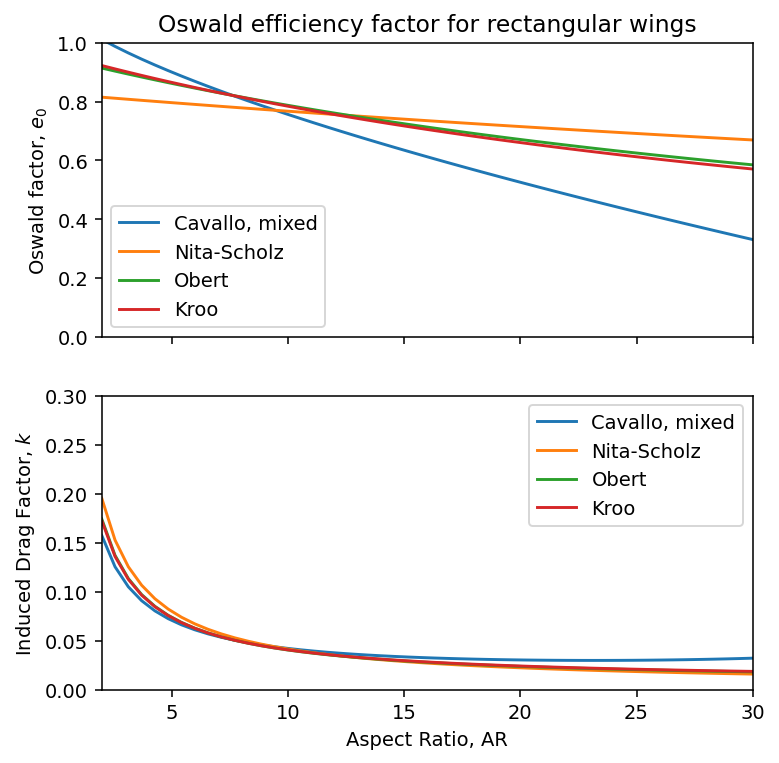

In [9]:
plot_e0_vs_AR(0, "Oswald efficiency factor for rectangular wings")

### Swept, Untapered Wing

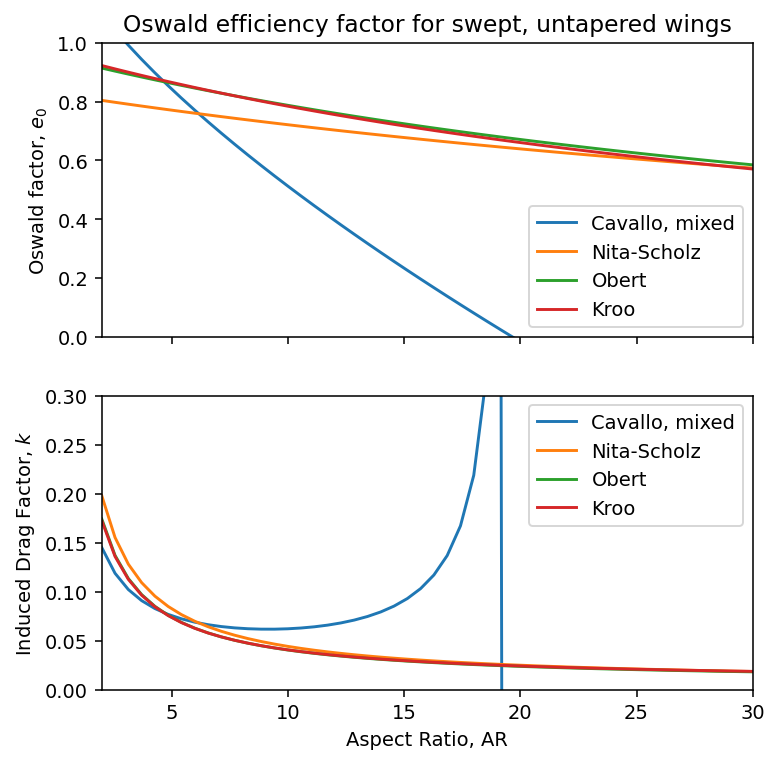

In [10]:
plot_e0_vs_AR(25, "Oswald efficiency factor for swept, untapered wings")

### Highly Swept, Untapered Wing

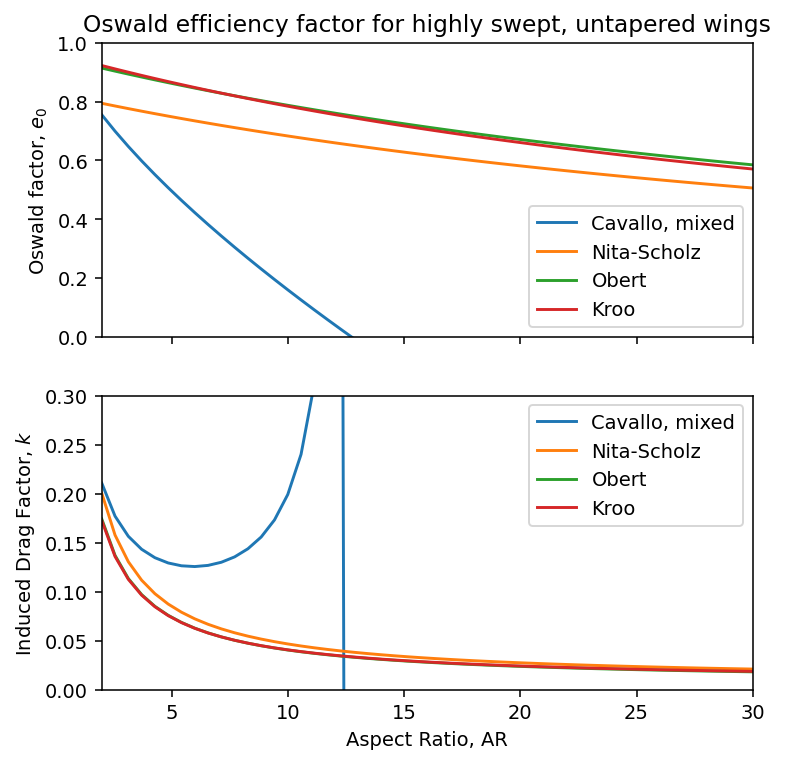

In [11]:
plot_e0_vs_AR(60, "Oswald efficiency factor for highly swept, untapered wings")

The above diagrams show how $k$ and $e_0$ change with $\text{AR}$.
Aircraft with highly-swept wing configurations also tend to have low aspect ratios (e.g. $\text{AR}_{\text{F-14}}=2.58$; $\text{AR}_{\text{EF-111}}=1.95$; $\text{AR}_{\text{M-2000C}}=2.03$) - in which case it should make sense to evaluate $e_0$ at low $\text{AR}$ (where the models generally show good agreement). 

## Estimating $k$ for Subsonic Aircraft: Biplane span efficiency factor

Values for Oswald span efficiency factor $e_0$ can be estimated from Biplane configurations.
From Prandtl:

$$e_0 = \frac{\mu^2 \cdot (1 + r)^2}{\mu^2 + 2 \sigma \mu r + r^2}$$

where
$$
\begin{eqnarray}
\mu \ \ &\doteq& \ \ \texttt{shorter span} \ \ &/& \ \ \texttt{longer span} \\
r \ \ &\doteq& \ \  \texttt{lift on shorter wing} \ \ &/& \ \ \texttt{lift on larger wing} \\
&\approx& \ \ \texttt{area of shorter wing} \ \ &/& \ \ \texttt{area of larger wing} \\
\sigma \ \ &\doteq& \ \  \texttt{interference factor}
\end{eqnarray}
$$

The greater the ratio of the gap between the wings and the average span of the wings, the lesser the interference factor $\sigma$.
The interference parameter is further reduced by decreasing the ratio $\mu$.
Raymer suggests that this result for $e_0$ optimistic, and it should be corrected by multiplying with a 0.8 fudge factor.